In [128]:
%pylab inline
import pandas as pd
import libaarhusxyz
import numpy as np
import SimPEG.electromagnetics.utils.static_instrument.dual

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/redhog/Projects/Emerald/experimental-pipeline-inversion/env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['inv']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Data preparation

Download data from https://purl.stanford.edu/vj301kx0276 and place it in the folder data/IncisedValley.

As this data is not in the original SkyTEM XYZ format, but has been converted to a CSV (the header has been stripped) we need to convert it back to that format. We also extract a single
flightlines so that the inversion in this example notebook doesn't take forever to run :)

In [313]:
x = libaarhusxyz.XYZ()
x.flightlines = pd.read_csv("data/IncisedValley/aem_processed_data_foothill_central_valley.csv")
#x.model_info["scalefactor"] = 1e12
x.model_info["scalefactor"] = 1
x.flightlines.TILT_X -= 270 # 0 degrees should be when frame is horizontal
x.flightlines.TILT_Y -= 270

x.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.xyz")

x = libaarhusxyz.XYZ("data/IncisedValley/aem_processed_data_foothill_central_valley.xyz", normalize=True)
filt = x.flightlines.title == 302701.0
x.flightlines = x.flightlines.loc[filt].reset_index(drop=True)
for key, value in x.layer_data.items():
    x.layer_data[key] = value.loc[filt].reset_index(drop=True)

x.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz")


# Inversion

Load the data int RAM, prepare a calibrated system description, invert the data and plot the result.

In [314]:
measured = libaarhusxyz.XYZ("data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz", normalize=True)
gex = libaarhusxyz.GEX("data/IncisedValley/aem_processed_data_foothill_central_valley.gex")

header [General] parsed
header [Channel1] parsed
header [Channel2] parsed


## Data plotting
Note that this is unprocessed and pretty noisy data

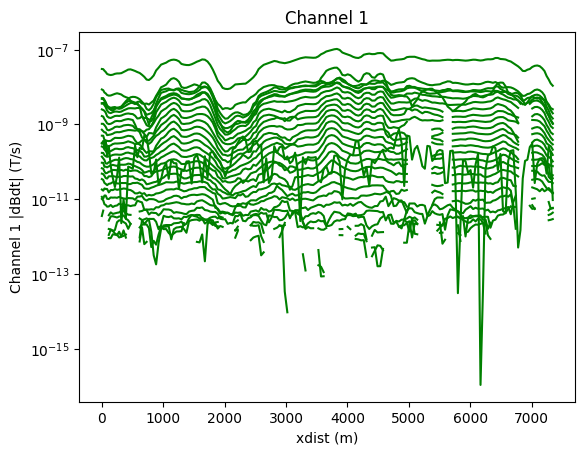

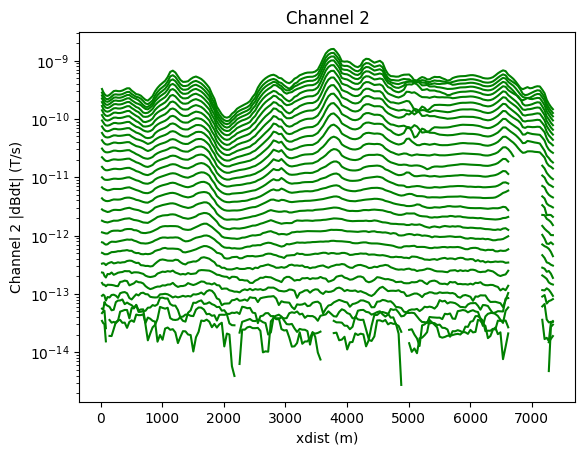

In [345]:
for channel in (1, 2):
    measured.plot_line(302701.0, channel=channel, ax=plt.gca(), color="green", label="Measured")
    plt.title("Channel %s" % channel)
    plt.show()

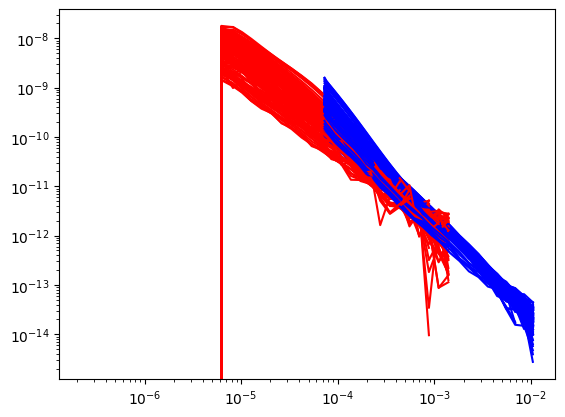

In [324]:
for row in range(0, len(measured.flightlines)):
    plt.loglog(gex.gate_times('Channel2')[:,0], measured.layer_data["dbdt_ch2gt"].iloc[row], color="blue")
    plt.loglog(gex.gate_times('Channel1')[:,0], measured.layer_data["dbdt_ch1gt"].iloc[row], color="red")
plt.show()

## Set up the iversion

We first create a calibrated system description using the GEX file. We then instantiate this system with the data.
As noted, the data is pretty noisy, so we filter out quite a few gates. In a real project, this would be done more
carefully and gates would be culled per sounding using the InUse flag columns of the xyz.

In [ ]:
CalibratedSystem = SimPEG.electromagnetics.utils.static_instrument.dual.DualMomentTEMXYZSystem.load_gex(gex)
inv = CalibratedSystem(
    measured,
    gate_filter__start_lm=7,
    gate_filter__end_lm=15,
    gate_filter__start_hm=15,
    gate_filter__end_hm=30,
)

## Sanity check plotting

Plot the filtered data, as it will go into the inversion

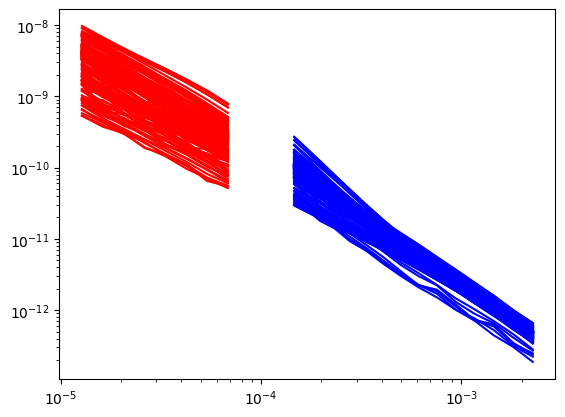

In [326]:
for row in range(0, len(inv.xyz.flightlines)):
    plt.loglog(inv.times[1], inv.xyz.layer_data["dbdt_ch2gt"].iloc[row], color="blue")
    plt.loglog(inv.times[0], inv.xyz.layer_data["dbdt_ch1gt"].iloc[row], color="red")
plt.show()

## Invert the data

In [318]:
inv.invert()

Using default (spLU) solver


/home/redhog/Projects/Emerald/experimental-pipeline-inversion/env/lib/python3.9/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh._cellGradStencil has been deprecated, please use TensorMesh.stencil_cell_gradient. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.50e+01  2.35e+05  0.00e+00  2.35e+05    8.64e+03      0              

                Default solver: SolverDiag is being used in bfgsH0
                
   1  7.49e+00  3.88e+04  1.44e+03  4.96e+04    8.55e+03      0              
   2  3.74e+00  6.95e+03  1.34e+03  1.20e+04    1.11e+03      0              
   3  1.87e+00  4.13e+03  1.50e+03  6.94e+03    7.01e+02      0   Skip BFGS  
   4  9.36e-01  2.96e+03  1.87e+03  4.70e+03    4.21e+02      0   Skip BFGS  
   5  4.68e-01  2.22e+03  2.39e+03  3.33e+03    2.61e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.3475e+04
1 : |xc-x_last| = 4.6605e+00 <= tolX*(1+|x0|) = 3.4128e+01

/home/redhog/Projects/Emerald/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:493: RuntimeWarning: divide by zero encountered in divide
  std = np.abs(1 / self.inv.invProb.dmisfit.W.diagonal() / self.inv.invProb.dmisfit.data.dobs)
/home/redhog/Projects/Emerald/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:493: RuntimeWarning: divide by zero encountered in divide
  std = np.abs(1 / self.inv.invProb.dmisfit.W.diagonal() / self.inv.invProb.dmisfit.data.dobs)
/home/redhog/Projects/Emerald/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:509: RuntimeWarning: invalid value encountered in divide
  xyzresp.flightlines['resdata'] = np.sqrt(np.nansum(derrall**2, axis=1) / (derrall > 0).sum(axis=1))


(None,
 data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz
 --------------------------------
                                                                  0
 scalefactor                                                    1.0
 inversion_type                                                None
 naming_standard                                       libaarhusxyz
 projection                                                    None
 source           data/IncisedValley/aem_processed_data_foothill...
 
 Soundings: 182
 Columns: 18
 Flightlines: 1
 Maximum layer depth: 710.1203559062233
 Projection: None
             x          y
 min  275058.0  4055251.2
 max  280045.7  4060348.5
        Resistivity
 count  5460.000000
 mean     57.191523
 std      31.089792
 min       9.032781
 25%      27.420466
 50%      54.814189
 75%      89.945963
 max     127.810558
 
 Layer data: resistivity
 Layer params: layer, dep_top, dep_bot)

# Plotting the resulting model
In this case, we have not set up the inversion to generate a sparse model (inv.sparse), only an l2 smooth model.
This model is a ibaarhusxyz.XYZ() object, and can be exported as an xyz file or a vtk.

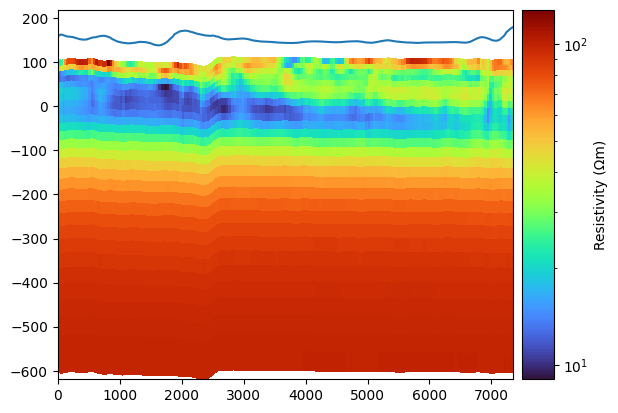

In [320]:
inv.l2.plot()

In [330]:
inv.l2.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.model.xyz")

In [329]:
inv.l2.to_vtk("data/IncisedValley/aem_processed_data_foothill_central_valley.model.vtk")

resistivity_variance_factor  is not in the given dataframe. this attribute will not be written to the VTK.
line_id  is not in the given dataframe. this attribute will not be written to the VTK.
tx_alt  is not in the given dataframe. this attribute will not be written to the VTK.
invalt  is not in the given dataframe. this attribute will not be written to the VTK.
invaltstd  is not in the given dataframe. this attribute will not be written to the VTK.
deltaalt  is not in the given dataframe. this attribute will not be written to the VTK.
numdata  is not in the given dataframe. this attribute will not be written to the VTK.
resdata  is not in the given dataframe. this attribute will not be written to the VTK.
restotal  is not in the given dataframe. this attribute will not be written to the VTK.
doi_upper  is not in the given dataframe. this attribute will not be written to the VTK.
doi_lower  is not in the given dataframe. this attribute will not be written to the VTK.


# Comparing the synthetic data

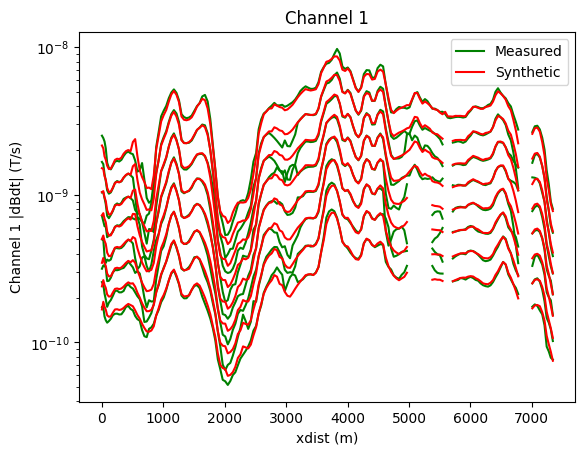

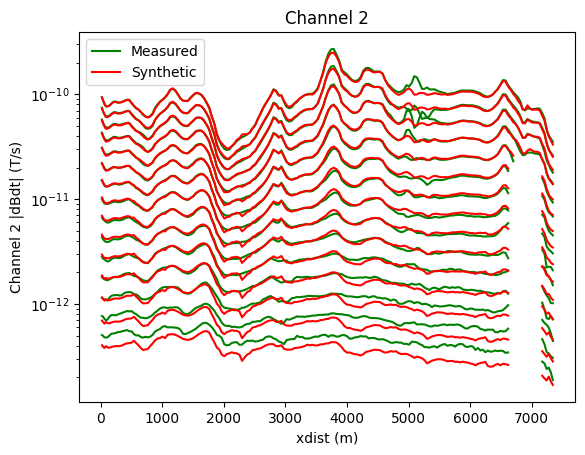

In [346]:
for channel in (1, 2):
    inv.xyz.plot_line(302701.0, channel=channel, ax=plt.gca(), color="green", label="Measured")
    inv.l2pred.plot_line(302701.0, channel=channel, ax=plt.gca(), color="red", label="Synthetic")
    plt.legend()
    plt.title("Channel %s" % channel)
    plt.show()


# Stand alone forward modelling
Forward modelling can be performed using the same system description as for inversions.
A model and a set of gate times are needed as input. Here we use the l2 model from the above inversion,
and the same gate times as in the original data

In [322]:
fwd = CalibratedSystem(inv.l2, times_full=inv.times_full)
l2data = fwd.forward()

Using default (spLU) solver


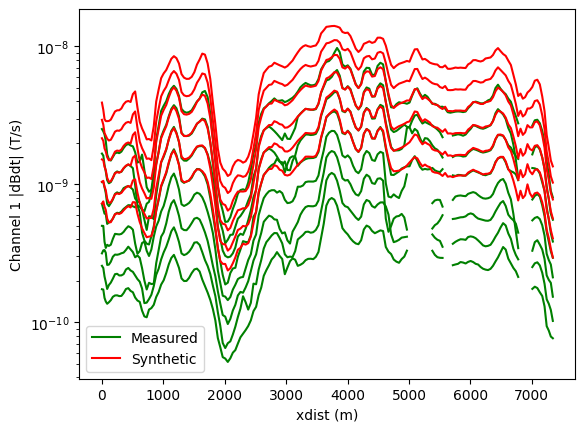

In [339]:
inv.xyz.plot_line(302701.0, ax=plt.gca(), color="green", label="Measured")
l2data.plot_line(302701.0, ax=plt.gca(), color="red", label="Synthetic")
plt.legend()
plt.show()